In [1]:
%matplotlib inline

# Data analysis

In this notebook you will find:
- Necessary imports
- Participant age information
- Number of dyslexic parents
- Function to calculate the average erp per class (risk/no risk)
- Frequency domain features
- Connectivity with stimulus and without 

Note: Make sure you run the data analysis notebook before to have the right paths in the `metadata.csv`!

# Imports

Below are the necessary imports for this notebook. mne_connectivity still needs to be added to the environment. 

In [2]:
import mne      # toolbox for analyzing and visualizing EEG data
import os       # using operating system dependent functionality (folders)
import pandas as pd # data analysis and manipulation
import numpy as np    # numerical computing (manipulating and performing operations on arrays of data)
import copy     # Can Copy and Deepcopy files so original file is untouched.
from ipywidgets import IntSlider, Output
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from math import nan

# Make sure that the 5 imports below are all installed using pip install ... 
from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_sensors_connectivity
import pyvista 
import mayavi
import vtk

import sys
sys.path.insert(0, '../eegyolk') # path to helper functions
import helper_functions as hf # library useful for eeg and erp data cleaning
import initialization_functions #library to import data
import epod_helper

The newest version of mne is necessary to run connectivity plots. If you don't have the latest version, uncomment and run the line below.

In [3]:
# pip install git+https://github.com/mne-tools/mne-python.git

## Load metadata

In the notebook `data_prep_eeg.ipynb` a csv-file `metadata.csv` is created. It is saved in the same folder as this notebook. The csv contains information about the participants and the corresponding eeg and epoch files. 

In [4]:
metadata = pd.read_csv('metadata.csv', sep = ',')

In [5]:
metadata

,eeg_file,ParticipantID,test,sex,age_months,age_months_days,dyslexic_parent,Group_AccToParents,eeg_path,path_epoch,epoch_file
0,101a,101,a,m,20,20;22,m,At risk,F:\Stage\ePODIUM\Data\ePodium (Projectfolder)\...,F:\Stage\ePODIUM\ePodium\dyslexiaprediction_na...,101a_epo.fif
1,101b,101,b,m,23,23;16,m,At risk,F:\Stage\ePODIUM\Data\ePodium (Projectfolder)\...,F:\Stage\ePODIUM\ePodium\dyslexiaprediction_na...,101b_epo.fif
2,102a,102,a,f,20,20;27,Nee,Control,F:\Stage\ePODIUM\Data\ePodium (Projectfolder)\...,F:\Stage\ePODIUM\ePodium\dyslexiaprediction_na...,102a_epo.fif
3,102b,102,b,f,23,23;16,Nee,Control,F:\Stage\ePODIUM\Data\ePodium (Projectfolder)\...,F:\Stage\ePODIUM\ePodium\dyslexiaprediction_na...,102b_epo.fif
4,103a,103,a,f,20,20;23,m,At risk,F:\Stage\ePODIUM\Data\ePodium (Projectfolder)\...,F:\Stage\ePODIUM\ePodium\dyslexiaprediction_na...,103a_epo.fif


## Participant information

The value to classify will be whether the participant is at risk for dyslexia or not. The age distribution for both groups is plotted below.

count     5.000000
mean     21.200000
std       1.643168
min      20.000000
25%      20.000000
50%      20.000000
75%      23.000000
max      23.000000
Name: age_months, dtype: float64

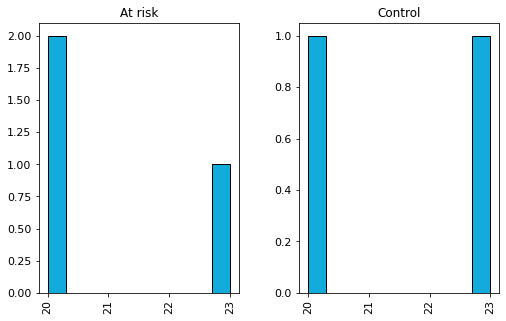

In [6]:
hist = metadata.hist(column='age_months',by='Group_AccToParents',color='#12ABDB',sharex=True, figsize=(8,5), xlabelsize=11, ylabelsize=11,bins=10,ec='black')
metadata['age_months'].describe()

Count of the gender for both groups. 

In [7]:
metadata.groupby('Group_AccToParents')['sex'].value_counts()

Group_AccToParents  sex
At risk             m      2
                    f      1
Control             f      2
Name: sex, dtype: int64

Count of whether the mom or dad is dyslexic or not. 

In [8]:
metadata.groupby('Group_AccToParents')['dyslexic_parent'].value_counts()

Group_AccToParents  dyslexic_parent
At risk             m                  3
Control             Nee                2
Name: dyslexic_parent, dtype: int64

## ERP per group

This function is able to calculate the average erp for a specific condition. The function needs a dataframe like `metadata.csv` which contains the epoch files and the participants characteristics. It also needs as input the characteristic we are interested in and a single value of this characteristic. For example if we want to look at the average erp for the children who are at risk, the group will be the column (feature) containing the values at risk or control and the value will be 'at risk'. The function also needs the event dictionary in order to average the epochs over multiple participants. 

In [9]:
event_dictionary = epod_helper.event_dictionary

def data_analysis(dataframe, group, value, event_dictionary):
    epochs = []
    evoked_pp = []
    dataframe = dataframe.loc[metadata[group] == value]
    
    for index, file in dataframe.iterrows():
        print(f"Checking out file: {file['epoch_file']}")
        path = os.path.join(file['path_epoch'], file['epoch_file'])
        epoch = mne.read_epochs(path, preload=False)
        epochs.append(epoch)
    
    evoked = hf.evoked_responses(epochs, event_dictionary)
    
    for i in range(len(evoked)):
        grand_avg = mne.grand_average(evoked[i])
        evoked_pp.append(grand_avg)
    
    grand_evoked = mne.grand_average(evoked_pp)
    
    return grand_evoked.plot(spatial_colors=True)

Checking out file: 101a_epo.fif
Reading F:\Stage\ePODIUM\ePodium\dyslexiaprediction_nadine\epochs\101a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2266 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 101b_epo.fif
Reading F:\Stage\ePODIUM\ePodium\dyslexiaprediction_nadine\epochs\101b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 103a_epo.fif
Reading F:\Stage\ePODIUM\ePodium\dyslexiaprediction_nadine\epochs\103a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2208 matching events found
No baseline correction applied
0 p

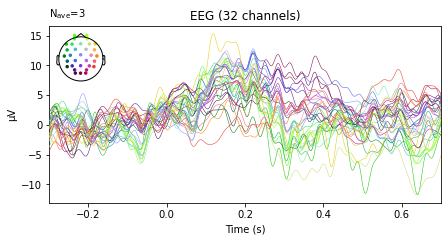

In [10]:
atrisk = data_analysis(metadata, group='Group_AccToParents', value = 'At risk', event_dictionary = epod_helper.event_dictionary)

Checking out file: 102a_epo.fif
Reading F:\Stage\ePODIUM\ePodium\dyslexiaprediction_nadine\epochs\102a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2389 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 102b_epo.fif
Reading F:\Stage\ePODIUM\ePodium\dyslexiaprediction_nadine\epochs\102b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


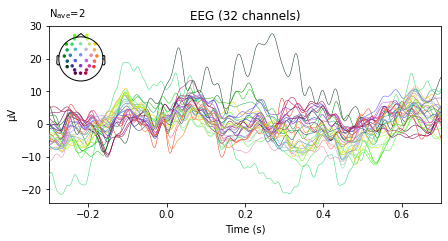

In [11]:
control = data_analysis(metadata, group='Group_AccToParents', value = 'Control', event_dictionary = epod_helper.event_dictionary)

Checking out file: 101a_epo.fif
Reading F:\Stage\ePODIUM\ePodium\dyslexiaprediction_nadine\epochs\101a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2266 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 102a_epo.fif
Reading F:\Stage\ePODIUM\ePodium\dyslexiaprediction_nadine\epochs\102a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2389 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 103a_epo.fif
Reading F:\Stage\ePODIUM\ePodium\dyslexiaprediction_nadine\epochs\103a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2208 matching events found
No baseline correction applied
0 p

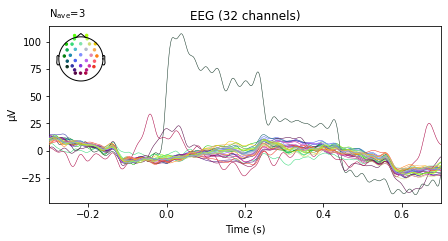

In [19]:
test_a = data_analysis(metadata, group='test', value = 'a', event_dictionary = epod_helper.event_dictionary)

Checking out file: 101b_epo.fif
Reading F:\Stage\ePODIUM\ePodium\dyslexiaprediction_nadine\epochs\101b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 102b_epo.fif
Reading F:\Stage\ePODIUM\ePodium\dyslexiaprediction_nadine\epochs\102b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


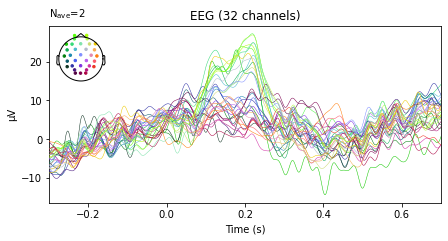

In [20]:
test_b = data_analysis(metadata, group='test', value = 'b', event_dictionary = epod_helper.event_dictionary)

## Connectivity 

In [12]:
dataframe = metadata
epochs = []
for index, file in dataframe.iterrows():
    print(f"Checking out file: {file['epoch_file']}")
    path = os.path.join(file['path_epoch'], file['epoch_file'])
    epoch = mne.read_epochs(path, preload=False)
    epochs.append(epoch)

Checking out file: 101a_epo.fif
Reading F:\Stage\ePODIUM\ePodium\dyslexiaprediction_nadine\epochs\101a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2266 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 101b_epo.fif
Reading F:\Stage\ePODIUM\ePodium\dyslexiaprediction_nadine\epochs\101b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 102a_epo.fif
Reading F:\Stage\ePODIUM\ePodium\dyslexiaprediction_nadine\epochs\102a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2389 matching events found
No baseline correction applied
0 p

Computing eeg connectivity

In [13]:
def data_connectivity(dataframe, group, value):
    epochs = []
    dataframe = dataframe.loc[metadata[group] == value]
    
    for index, file in dataframe.iterrows():
        print(f"Checking out file: {file['epoch_file']}")
        path = os.path.join(file['path_epoch'], file['epoch_file'])
        epoch = mne.read_epochs(path, preload=False)
        epochs.append(epoch)
    
    epochs_con = mne.concatenate_epochs(epochs)
    
    fmin, fmax = 4., 9.
    sfreq = epochs_con.info['sfreq']  # the sampling frequency
    tmin = 0.0  # exclude the baseline period
    
    con = spectral_connectivity_epochs(
        epochs_con, method='pli', mode='multitaper', fmin=fmin, fmax=fmax,
        faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=1)

    # Now, visualize the connectivity in 3D:
    
    return plot_sensors_connectivity(epochs_con.info, con.get_data(output='dense')[:, :, 0])

In [16]:
connectivity_atrisk = data_connectivity(metadata, group='Group_AccToParents', value = 'At risk')

Checking out file: 101a_epo.fif
Reading F:\Stage\ePODIUM\ePodium\dyslexiaprediction_nadine\epochs\101a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2266 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 101b_epo.fif
Reading F:\Stage\ePODIUM\ePodium\dyslexiaprediction_nadine\epochs\101b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 103a_epo.fif
Reading F:\Stage\ePODIUM\ePodium\dyslexiaprediction_nadine\epochs\103a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2208 matching events found
No baseline correction applied
0 p

<ipython-input-13-9f3e326ae38f>:17: RuntimeWarning: There were no Annotations stored in <Epochs |  6914 events (all good), -0.299805 - 0.700195 sec, baseline -0.299805 – 0 sec, ~3.38 GB, data loaded,
 '1': 383
 '2': 1053
 '3': 354
 '4': 364
 '5': 1004
 '6': 334
 '7': 366
 '8': 986
 '9': 337
 '10': 372
 and 2 more events ...>, so metadata was not modified.
  con = spectral_connectivity_epochs(


only using indices for lower-triangular matrix
    computing connectivity for 496 connections
    using t=0.000s..0.700s for estimation (1435 points)
    frequencies: 4.3Hz..8.6Hz (4 points)
    connectivity scores will be averaged for each band


<ipython-input-13-9f3e326ae38f>:17: RuntimeWarning: fmin=4.000 Hz corresponds to 2.803 < 5 cycles based on the epoch length 0.701 sec, need at least 1.250 sec epochs or fmin=7.136. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connec

    computing connectivity for epoch 201
    computing connectivity for epoch 202
    computing connectivity for epoch 203
    computing connectivity for epoch 204
    computing connectivity for epoch 205
    computing connectivity for epoch 206
    computing connectivity for epoch 207
    computing connectivity for epoch 208
    computing connectivity for epoch 209
    computing connectivity for epoch 210
    computing connectivity for epoch 211
    computing connectivity for epoch 212
    computing connectivity for epoch 213
    computing connectivity for epoch 214
    computing connectivity for epoch 215
    computing connectivity for epoch 216
    computing connectivity for epoch 217
    computing connectivity for epoch 218
    computing connectivity for epoch 219
    computing connectivity for epoch 220
    computing connectivity for epoch 221
    computing connectivity for epoch 222
    computing connectivity for epoch 223
    computing connectivity for epoch 224
    computing co

    computing connectivity for epoch 401
    computing connectivity for epoch 402
    computing connectivity for epoch 403
    computing connectivity for epoch 404
    computing connectivity for epoch 405
    computing connectivity for epoch 406
    computing connectivity for epoch 407
    computing connectivity for epoch 408
    computing connectivity for epoch 409
    computing connectivity for epoch 410
    computing connectivity for epoch 411
    computing connectivity for epoch 412
    computing connectivity for epoch 413
    computing connectivity for epoch 414
    computing connectivity for epoch 415
    computing connectivity for epoch 416
    computing connectivity for epoch 417
    computing connectivity for epoch 418
    computing connectivity for epoch 419
    computing connectivity for epoch 420
    computing connectivity for epoch 421
    computing connectivity for epoch 422
    computing connectivity for epoch 423
    computing connectivity for epoch 424
    computing co

KeyboardInterrupt: 

In [15]:
connectivity_control = data_connectivity(metadata, group='Group_AccToParents', value = 'Control')

Checking out file: 102a_epo.fif
Reading F:\Stage\ePODIUM\ePodium\dyslexiaprediction_nadine\epochs\102a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2389 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 102b_epo.fif
Reading F:\Stage\ePODIUM\ePodium\dyslexiaprediction_nadine\epochs\102b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Loading data for 2389 events and 2049 original time points ...
Loading data for 2440 events and 2049 original time points ...
Not setting metadata
4829 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Connectivity computation...
only using indices for lower-triangular matrix
    

<ipython-input-13-9f3e326ae38f>:17: RuntimeWarning: There were no Annotations stored in <Epochs |  4829 events (all good), -0.299805 - 0.700195 sec, baseline -0.299805 – 0 sec, ~2.36 GB, data loaded,
 '1': 260
 '2': 720
 '3': 240
 '4': 249
 '5': 691
 '6': 229
 '7': 260
 '8': 720
 '9': 240
 '10': 260
 and 2 more events ...>, so metadata was not modified.
  con = spectral_connectivity_epochs(
<ipython-input-13-9f3e326ae38f>:17: RuntimeWarning: fmin=4.000 Hz corresponds to 2.803 < 5 cycles based on the epoch length 0.701 sec, need at least 1.250 sec epochs or fmin=7.136. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    c

    computing connectivity for epoch 208
    computing connectivity for epoch 209
    computing connectivity for epoch 210
    computing connectivity for epoch 211
    computing connectivity for epoch 212
    computing connectivity for epoch 213
    computing connectivity for epoch 214
    computing connectivity for epoch 215
    computing connectivity for epoch 216
    computing connectivity for epoch 217
    computing connectivity for epoch 218
    computing connectivity for epoch 219
    computing connectivity for epoch 220
    computing connectivity for epoch 221
    computing connectivity for epoch 222
    computing connectivity for epoch 223
    computing connectivity for epoch 224
    computing connectivity for epoch 225
    computing connectivity for epoch 226
    computing connectivity for epoch 227
    computing connectivity for epoch 228
    computing connectivity for epoch 229
    computing connectivity for epoch 230
    computing connectivity for epoch 231
    computing co

    computing connectivity for epoch 408
    computing connectivity for epoch 409
    computing connectivity for epoch 410
    computing connectivity for epoch 411
    computing connectivity for epoch 412
    computing connectivity for epoch 413
    computing connectivity for epoch 414
    computing connectivity for epoch 415
    computing connectivity for epoch 416
    computing connectivity for epoch 417
    computing connectivity for epoch 418
    computing connectivity for epoch 419
    computing connectivity for epoch 420
    computing connectivity for epoch 421
    computing connectivity for epoch 422
    computing connectivity for epoch 423
    computing connectivity for epoch 424
    computing connectivity for epoch 425
    computing connectivity for epoch 426
    computing connectivity for epoch 427
    computing connectivity for epoch 428
    computing connectivity for epoch 429
    computing connectivity for epoch 430
    computing connectivity for epoch 431
    computing co

    computing connectivity for epoch 608
    computing connectivity for epoch 609
    computing connectivity for epoch 610
    computing connectivity for epoch 611
    computing connectivity for epoch 612
    computing connectivity for epoch 613
    computing connectivity for epoch 614
    computing connectivity for epoch 615
    computing connectivity for epoch 616
    computing connectivity for epoch 617
    computing connectivity for epoch 618
    computing connectivity for epoch 619
    computing connectivity for epoch 620
    computing connectivity for epoch 621
    computing connectivity for epoch 622
    computing connectivity for epoch 623
    computing connectivity for epoch 624
    computing connectivity for epoch 625
    computing connectivity for epoch 626
    computing connectivity for epoch 627
    computing connectivity for epoch 628
    computing connectivity for epoch 629
    computing connectivity for epoch 630
    computing connectivity for epoch 631
    computing co

    computing connectivity for epoch 808
    computing connectivity for epoch 809
    computing connectivity for epoch 810
    computing connectivity for epoch 811
    computing connectivity for epoch 812
    computing connectivity for epoch 813
    computing connectivity for epoch 814
    computing connectivity for epoch 815
    computing connectivity for epoch 816
    computing connectivity for epoch 817
    computing connectivity for epoch 818
    computing connectivity for epoch 819
    computing connectivity for epoch 820
    computing connectivity for epoch 821
    computing connectivity for epoch 822
    computing connectivity for epoch 823
    computing connectivity for epoch 824
    computing connectivity for epoch 825
    computing connectivity for epoch 826
    computing connectivity for epoch 827
    computing connectivity for epoch 828
    computing connectivity for epoch 829
    computing connectivity for epoch 830
    computing connectivity for epoch 831
    computing co

    computing connectivity for epoch 1008
    computing connectivity for epoch 1009
    computing connectivity for epoch 1010
    computing connectivity for epoch 1011
    computing connectivity for epoch 1012
    computing connectivity for epoch 1013
    computing connectivity for epoch 1014
    computing connectivity for epoch 1015
    computing connectivity for epoch 1016
    computing connectivity for epoch 1017
    computing connectivity for epoch 1018
    computing connectivity for epoch 1019
    computing connectivity for epoch 1020
    computing connectivity for epoch 1021
    computing connectivity for epoch 1022
    computing connectivity for epoch 1023
    computing connectivity for epoch 1024
    computing connectivity for epoch 1025
    computing connectivity for epoch 1026
    computing connectivity for epoch 1027
    computing connectivity for epoch 1028
    computing connectivity for epoch 1029
    computing connectivity for epoch 1030
    computing connectivity for epo

    computing connectivity for epoch 1204
    computing connectivity for epoch 1205
    computing connectivity for epoch 1206
    computing connectivity for epoch 1207
    computing connectivity for epoch 1208
    computing connectivity for epoch 1209
    computing connectivity for epoch 1210
    computing connectivity for epoch 1211
    computing connectivity for epoch 1212
    computing connectivity for epoch 1213
    computing connectivity for epoch 1214
    computing connectivity for epoch 1215
    computing connectivity for epoch 1216
    computing connectivity for epoch 1217
    computing connectivity for epoch 1218
    computing connectivity for epoch 1219
    computing connectivity for epoch 1220
    computing connectivity for epoch 1221
    computing connectivity for epoch 1222
    computing connectivity for epoch 1223
    computing connectivity for epoch 1224
    computing connectivity for epoch 1225
    computing connectivity for epoch 1226
    computing connectivity for epo

    computing connectivity for epoch 1400
    computing connectivity for epoch 1401
    computing connectivity for epoch 1402
    computing connectivity for epoch 1403
    computing connectivity for epoch 1404
    computing connectivity for epoch 1405
    computing connectivity for epoch 1406
    computing connectivity for epoch 1407
    computing connectivity for epoch 1408
    computing connectivity for epoch 1409
    computing connectivity for epoch 1410
    computing connectivity for epoch 1411
    computing connectivity for epoch 1412
    computing connectivity for epoch 1413
    computing connectivity for epoch 1414
    computing connectivity for epoch 1415
    computing connectivity for epoch 1416
    computing connectivity for epoch 1417
    computing connectivity for epoch 1418
    computing connectivity for epoch 1419
    computing connectivity for epoch 1420
    computing connectivity for epoch 1421
    computing connectivity for epoch 1422
    computing connectivity for epo

    computing connectivity for epoch 1596
    computing connectivity for epoch 1597
    computing connectivity for epoch 1598
    computing connectivity for epoch 1599
    computing connectivity for epoch 1600
    computing connectivity for epoch 1601
    computing connectivity for epoch 1602
    computing connectivity for epoch 1603
    computing connectivity for epoch 1604
    computing connectivity for epoch 1605
    computing connectivity for epoch 1606
    computing connectivity for epoch 1607
    computing connectivity for epoch 1608
    computing connectivity for epoch 1609
    computing connectivity for epoch 1610
    computing connectivity for epoch 1611
    computing connectivity for epoch 1612
    computing connectivity for epoch 1613
    computing connectivity for epoch 1614
    computing connectivity for epoch 1615
    computing connectivity for epoch 1616
    computing connectivity for epoch 1617
    computing connectivity for epoch 1618
    computing connectivity for epo

    computing connectivity for epoch 1792
    computing connectivity for epoch 1793
    computing connectivity for epoch 1794
    computing connectivity for epoch 1795
    computing connectivity for epoch 1796
    computing connectivity for epoch 1797
    computing connectivity for epoch 1798
    computing connectivity for epoch 1799
    computing connectivity for epoch 1800
    computing connectivity for epoch 1801
    computing connectivity for epoch 1802
    computing connectivity for epoch 1803
    computing connectivity for epoch 1804
    computing connectivity for epoch 1805
    computing connectivity for epoch 1806
    computing connectivity for epoch 1807
    computing connectivity for epoch 1808
    computing connectivity for epoch 1809
    computing connectivity for epoch 1810
    computing connectivity for epoch 1811
    computing connectivity for epoch 1812
    computing connectivity for epoch 1813
    computing connectivity for epoch 1814
    computing connectivity for epo

    computing connectivity for epoch 1988
    computing connectivity for epoch 1989
    computing connectivity for epoch 1990
    computing connectivity for epoch 1991
    computing connectivity for epoch 1992
    computing connectivity for epoch 1993
    computing connectivity for epoch 1994
    computing connectivity for epoch 1995
    computing connectivity for epoch 1996
    computing connectivity for epoch 1997
    computing connectivity for epoch 1998
    computing connectivity for epoch 1999
    computing connectivity for epoch 2000
    computing connectivity for epoch 2001
    computing connectivity for epoch 2002
    computing connectivity for epoch 2003
    computing connectivity for epoch 2004
    computing connectivity for epoch 2005
    computing connectivity for epoch 2006
    computing connectivity for epoch 2007
    computing connectivity for epoch 2008
    computing connectivity for epoch 2009
    computing connectivity for epoch 2010
    computing connectivity for epo

    computing connectivity for epoch 2184
    computing connectivity for epoch 2185
    computing connectivity for epoch 2186
    computing connectivity for epoch 2187
    computing connectivity for epoch 2188
    computing connectivity for epoch 2189
    computing connectivity for epoch 2190
    computing connectivity for epoch 2191
    computing connectivity for epoch 2192
    computing connectivity for epoch 2193
    computing connectivity for epoch 2194
    computing connectivity for epoch 2195
    computing connectivity for epoch 2196
    computing connectivity for epoch 2197
    computing connectivity for epoch 2198
    computing connectivity for epoch 2199
    computing connectivity for epoch 2200
    computing connectivity for epoch 2201
    computing connectivity for epoch 2202
    computing connectivity for epoch 2203
    computing connectivity for epoch 2204
    computing connectivity for epoch 2205
    computing connectivity for epoch 2206
    computing connectivity for epo

    computing connectivity for epoch 2380
    computing connectivity for epoch 2381
    computing connectivity for epoch 2382
    computing connectivity for epoch 2383
    computing connectivity for epoch 2384
    computing connectivity for epoch 2385
    computing connectivity for epoch 2386
    computing connectivity for epoch 2387
    computing connectivity for epoch 2388
    computing connectivity for epoch 2389
    computing connectivity for epoch 2390
    computing connectivity for epoch 2391
    computing connectivity for epoch 2392
    computing connectivity for epoch 2393
    computing connectivity for epoch 2394
    computing connectivity for epoch 2395
    computing connectivity for epoch 2396
    computing connectivity for epoch 2397
    computing connectivity for epoch 2398
    computing connectivity for epoch 2399
    computing connectivity for epoch 2400
    computing connectivity for epoch 2401
    computing connectivity for epoch 2402
    computing connectivity for epo

    computing connectivity for epoch 2576
    computing connectivity for epoch 2577
    computing connectivity for epoch 2578
    computing connectivity for epoch 2579
    computing connectivity for epoch 2580
    computing connectivity for epoch 2581
    computing connectivity for epoch 2582
    computing connectivity for epoch 2583
    computing connectivity for epoch 2584
    computing connectivity for epoch 2585
    computing connectivity for epoch 2586
    computing connectivity for epoch 2587
    computing connectivity for epoch 2588
    computing connectivity for epoch 2589
    computing connectivity for epoch 2590
    computing connectivity for epoch 2591
    computing connectivity for epoch 2592
    computing connectivity for epoch 2593
    computing connectivity for epoch 2594
    computing connectivity for epoch 2595
    computing connectivity for epoch 2596
    computing connectivity for epoch 2597
    computing connectivity for epoch 2598
    computing connectivity for epo

    computing connectivity for epoch 2772
    computing connectivity for epoch 2773
    computing connectivity for epoch 2774
    computing connectivity for epoch 2775
    computing connectivity for epoch 2776
    computing connectivity for epoch 2777
    computing connectivity for epoch 2778
    computing connectivity for epoch 2779
    computing connectivity for epoch 2780
    computing connectivity for epoch 2781
    computing connectivity for epoch 2782
    computing connectivity for epoch 2783
    computing connectivity for epoch 2784
    computing connectivity for epoch 2785
    computing connectivity for epoch 2786
    computing connectivity for epoch 2787
    computing connectivity for epoch 2788
    computing connectivity for epoch 2789
    computing connectivity for epoch 2790
    computing connectivity for epoch 2791
    computing connectivity for epoch 2792
    computing connectivity for epoch 2793
    computing connectivity for epoch 2794
    computing connectivity for epo

    computing connectivity for epoch 2968
    computing connectivity for epoch 2969
    computing connectivity for epoch 2970
    computing connectivity for epoch 2971
    computing connectivity for epoch 2972
    computing connectivity for epoch 2973
    computing connectivity for epoch 2974
    computing connectivity for epoch 2975
    computing connectivity for epoch 2976
    computing connectivity for epoch 2977
    computing connectivity for epoch 2978
    computing connectivity for epoch 2979
    computing connectivity for epoch 2980
    computing connectivity for epoch 2981
    computing connectivity for epoch 2982
    computing connectivity for epoch 2983
    computing connectivity for epoch 2984
    computing connectivity for epoch 2985
    computing connectivity for epoch 2986
    computing connectivity for epoch 2987
    computing connectivity for epoch 2988
    computing connectivity for epoch 2989
    computing connectivity for epoch 2990
    computing connectivity for epo

    computing connectivity for epoch 3164
    computing connectivity for epoch 3165
    computing connectivity for epoch 3166
    computing connectivity for epoch 3167
    computing connectivity for epoch 3168
    computing connectivity for epoch 3169
    computing connectivity for epoch 3170
    computing connectivity for epoch 3171
    computing connectivity for epoch 3172
    computing connectivity for epoch 3173
    computing connectivity for epoch 3174
    computing connectivity for epoch 3175
    computing connectivity for epoch 3176
    computing connectivity for epoch 3177
    computing connectivity for epoch 3178
    computing connectivity for epoch 3179
    computing connectivity for epoch 3180
    computing connectivity for epoch 3181
    computing connectivity for epoch 3182
    computing connectivity for epoch 3183
    computing connectivity for epoch 3184
    computing connectivity for epoch 3185
    computing connectivity for epoch 3186
    computing connectivity for epo

    computing connectivity for epoch 3360
    computing connectivity for epoch 3361
    computing connectivity for epoch 3362
    computing connectivity for epoch 3363
    computing connectivity for epoch 3364
    computing connectivity for epoch 3365
    computing connectivity for epoch 3366
    computing connectivity for epoch 3367
    computing connectivity for epoch 3368
    computing connectivity for epoch 3369
    computing connectivity for epoch 3370
    computing connectivity for epoch 3371
    computing connectivity for epoch 3372
    computing connectivity for epoch 3373
    computing connectivity for epoch 3374
    computing connectivity for epoch 3375
    computing connectivity for epoch 3376
    computing connectivity for epoch 3377
    computing connectivity for epoch 3378
    computing connectivity for epoch 3379
    computing connectivity for epoch 3380
    computing connectivity for epoch 3381
    computing connectivity for epoch 3382
    computing connectivity for epo

    computing connectivity for epoch 3556
    computing connectivity for epoch 3557
    computing connectivity for epoch 3558
    computing connectivity for epoch 3559
    computing connectivity for epoch 3560
    computing connectivity for epoch 3561
    computing connectivity for epoch 3562
    computing connectivity for epoch 3563
    computing connectivity for epoch 3564
    computing connectivity for epoch 3565
    computing connectivity for epoch 3566
    computing connectivity for epoch 3567
    computing connectivity for epoch 3568
    computing connectivity for epoch 3569
    computing connectivity for epoch 3570
    computing connectivity for epoch 3571
    computing connectivity for epoch 3572
    computing connectivity for epoch 3573
    computing connectivity for epoch 3574
    computing connectivity for epoch 3575
    computing connectivity for epoch 3576
    computing connectivity for epoch 3577
    computing connectivity for epoch 3578
    computing connectivity for epo

    computing connectivity for epoch 3752
    computing connectivity for epoch 3753
    computing connectivity for epoch 3754
    computing connectivity for epoch 3755
    computing connectivity for epoch 3756
    computing connectivity for epoch 3757
    computing connectivity for epoch 3758
    computing connectivity for epoch 3759
    computing connectivity for epoch 3760
    computing connectivity for epoch 3761
    computing connectivity for epoch 3762
    computing connectivity for epoch 3763
    computing connectivity for epoch 3764
    computing connectivity for epoch 3765
    computing connectivity for epoch 3766
    computing connectivity for epoch 3767
    computing connectivity for epoch 3768
    computing connectivity for epoch 3769
    computing connectivity for epoch 3770
    computing connectivity for epoch 3771
    computing connectivity for epoch 3772
    computing connectivity for epoch 3773
    computing connectivity for epoch 3774
    computing connectivity for epo

    computing connectivity for epoch 3948
    computing connectivity for epoch 3949
    computing connectivity for epoch 3950
    computing connectivity for epoch 3951
    computing connectivity for epoch 3952
    computing connectivity for epoch 3953
    computing connectivity for epoch 3954
    computing connectivity for epoch 3955
    computing connectivity for epoch 3956
    computing connectivity for epoch 3957
    computing connectivity for epoch 3958
    computing connectivity for epoch 3959
    computing connectivity for epoch 3960
    computing connectivity for epoch 3961
    computing connectivity for epoch 3962
    computing connectivity for epoch 3963
    computing connectivity for epoch 3964
    computing connectivity for epoch 3965
    computing connectivity for epoch 3966
    computing connectivity for epoch 3967
    computing connectivity for epoch 3968
    computing connectivity for epoch 3969
    computing connectivity for epoch 3970
    computing connectivity for epo

    computing connectivity for epoch 4144
    computing connectivity for epoch 4145
    computing connectivity for epoch 4146
    computing connectivity for epoch 4147
    computing connectivity for epoch 4148
    computing connectivity for epoch 4149
    computing connectivity for epoch 4150
    computing connectivity for epoch 4151
    computing connectivity for epoch 4152
    computing connectivity for epoch 4153
    computing connectivity for epoch 4154
    computing connectivity for epoch 4155
    computing connectivity for epoch 4156
    computing connectivity for epoch 4157
    computing connectivity for epoch 4158
    computing connectivity for epoch 4159
    computing connectivity for epoch 4160
    computing connectivity for epoch 4161
    computing connectivity for epoch 4162
    computing connectivity for epoch 4163
    computing connectivity for epoch 4164
    computing connectivity for epoch 4165
    computing connectivity for epoch 4166
    computing connectivity for epo

    computing connectivity for epoch 4340
    computing connectivity for epoch 4341
    computing connectivity for epoch 4342
    computing connectivity for epoch 4343
    computing connectivity for epoch 4344
    computing connectivity for epoch 4345
    computing connectivity for epoch 4346
    computing connectivity for epoch 4347
    computing connectivity for epoch 4348
    computing connectivity for epoch 4349
    computing connectivity for epoch 4350
    computing connectivity for epoch 4351
    computing connectivity for epoch 4352
    computing connectivity for epoch 4353
    computing connectivity for epoch 4354
    computing connectivity for epoch 4355
    computing connectivity for epoch 4356
    computing connectivity for epoch 4357
    computing connectivity for epoch 4358
    computing connectivity for epoch 4359
    computing connectivity for epoch 4360
    computing connectivity for epoch 4361
    computing connectivity for epoch 4362
    computing connectivity for epo

    computing connectivity for epoch 4536
    computing connectivity for epoch 4537
    computing connectivity for epoch 4538
    computing connectivity for epoch 4539
    computing connectivity for epoch 4540
    computing connectivity for epoch 4541
    computing connectivity for epoch 4542
    computing connectivity for epoch 4543
    computing connectivity for epoch 4544
    computing connectivity for epoch 4545
    computing connectivity for epoch 4546
    computing connectivity for epoch 4547
    computing connectivity for epoch 4548
    computing connectivity for epoch 4549
    computing connectivity for epoch 4550
    computing connectivity for epoch 4551
    computing connectivity for epoch 4552
    computing connectivity for epoch 4553
    computing connectivity for epoch 4554
    computing connectivity for epoch 4555
    computing connectivity for epoch 4556
    computing connectivity for epoch 4557
    computing connectivity for epoch 4558
    computing connectivity for epo

    computing connectivity for epoch 4732
    computing connectivity for epoch 4733
    computing connectivity for epoch 4734
    computing connectivity for epoch 4735
    computing connectivity for epoch 4736
    computing connectivity for epoch 4737
    computing connectivity for epoch 4738
    computing connectivity for epoch 4739
    computing connectivity for epoch 4740
    computing connectivity for epoch 4741
    computing connectivity for epoch 4742
    computing connectivity for epoch 4743
    computing connectivity for epoch 4744
    computing connectivity for epoch 4745
    computing connectivity for epoch 4746
    computing connectivity for epoch 4747
    computing connectivity for epoch 4748
    computing connectivity for epoch 4749
    computing connectivity for epoch 4750
    computing connectivity for epoch 4751
    computing connectivity for epoch 4752
    computing connectivity for epoch 4753
    computing connectivity for epoch 4754
    computing connectivity for epo